# Определение стоимости автомобилей

_____
**Описание исследования.**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


_____
**Цели исследования.**
    
Построить модель для определения стоимости.


_____
**Исходные данные.**
    
**Признаки:**

- DateCrawled — дата скачивания анкеты из базы

- VehicleType — тип автомобильного кузова

- RegistrationYear — год регистрации автомобиля

- Gearbox — тип коробки передач

- Power — мощность (л. с.)

- Model — модель автомобиля

- Kilometer — пробег (км)

- RegistrationMonth — месяц регистрации автомобиля

- FuelType — тип топлива

- Brand — марка автомобиля

- Repaired — была машина в ремонте или нет

- DateCreated — дата создания анкеты

- NumberOfPictures — количество фотографий автомобиля

- PostalCode — почтовый индекс владельца анкеты (пользователя)

- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)
_____
**Данное исследование разделим на три этапа:**



1. Выполнить загрузку и подготовку данных.


2. Провести обучение и проверку моделей.


3. Анализ моделей.




### Библиотеки и окружение

In [ ]:
!pip install matplotlib==3.8.4 -q

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-learn==1.4.0 -q

In [ ]:
pip install phik==0.12.4 -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install seaborn==0.13.2 -q

In [ ]:
!pip install shap==0.45.1 -q

In [ ]:
!pip install catboost optuna -q

In [ ]:
! pip install lightgbm==3.3.1 -q
import lightgbm

from scipy.stats import shapiro

In [ ]:
import xgboost as xgb

In [ ]:
import optuna

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
import math
import time

In [ ]:
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.compose import make_column_transformer, make_column_selector

In [ ]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
import os

**Функции:**

In [ ]:
# Вывод уникальных значений, количества пропусков и дубликатов.
def check(row):
    col = row.columns
    dupli = row.duplicated().sum()
    print('Количество явных дубликатов:', dupli)
    # nans = row.isna().sum().sum()
    print('Количество пропусков в данных:', row.isna().sum().sum())
    #print(df[col].isna().sum())
    for col_l in col:
        print('-'* 30)
        print('Уникальные значения:', col_l, row[col_l].sort_values().unique())
        print('Количество пропусков:',df[col_l].isna().sum())

In [ ]:
def row_signs(row, columns):
    for column in columns:
        sign(row,column,column)


In [ ]:
# Вывод гистограмм, pie-диаграмм, сводных таблиц
def sign(row,column, title):
    if row.dtypes[column] == object:
        row[column].value_counts().plot.barh(figsize=(10, 5), grid= True)
        plt.title(title, fontsize=15)
        plt.ylabel('Количество')
        plt.rc('xtick', labelsize= 15 )
        plt.rc('ytick', labelsize= 15 )
        plt.show()
        one = pd.pivot_table(
            row,
            index=column,
            #values = index,
            aggfunc='count')
        plt.title(title, fontsize=20)
        row[column].value_counts().plot(
            kind = 'pie',
            figsize=(10,10),
            autopct = '%0.01f%%',
            colors=sns.color_palette('Set2')
        )
        ax = plt.gca()
        #ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.show()


    else:
        fig, axes = plt.subplots(2, figsize=(15, 15), sharey='row')
        #axes[0].plot(row[column], kind='bar')
        axes[0].hist(row[column], bins=int(len(row) ** (0.5)))
        axes[0].grid(True)
        axes[0].set_title(title, fontsize=20)
        axes[0].set_ylabel('Количество')
        axes[1].boxplot(data=row, x=column, vert=False, patch_artist=True)
        axes[1].grid(True)
        axes[1].set_xlabel(title)
        plt.show()
        return row[column].describe().T

In [ ]:
def phikmatrix(row):
    if 'id' in row.columns:
        phik_overview = (row.drop('id', axis=1).phik_matrix(verbose=False))
    else:
        phik_overview = (row.phik_matrix(verbose=False))
    matrix = np.triu(phik_overview .corr())
    plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='RdPu',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Переменные**:

In [ ]:
RANDOM_STATE = 42

## Подготовка данных

In [ ]:
# Загрузка данных
pth1 = '/datasets/autos.csv'
pth2 = 'datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
check(df)

Количество явных дубликатов: 4
Количество пропусков в данных: 181077
------------------------------
Уникальные значения: DateCrawled ['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']
Количество пропусков: 0
------------------------------
Уникальные значения: Price [    0     1     2 ... 19998 19999 20000]
Количество пропусков: 0
------------------------------
Уникальные значения: VehicleType ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
Количество пропусков: 37490
------------------------------
Уникальные значения: RegistrationYear [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 19

In [ ]:
df = df.drop_duplicates()

In [ ]:
df['Model'] = df['Model'].str.replace('rangerover', 'range_rover')


In [ ]:
time_to_datetime = ['DateCrawled', 'LastSeen', 'DateCreated']
for i in time_to_datetime:
    df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S')

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

#### Промежуточный вывод:

- Столбец NumberOfPictures не информативен и содержит всего одно значение, принято решение убрать его из датасета для построения модели.
- PostalCode — почтовый индекс владельца анкеты (пользователя) и DateCrawled, LastSeen, RegistrationMonth не информативны.


In [ ]:
df['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

Последнее объявление выгружено в 2016 году.

In [ ]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'PostalCode', 'LastSeen', 'RegistrationMonth' , 'DateCreated'], axis=1)

In [ ]:
drop = df.query('RegistrationYear > 2016')
drop

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
48,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,gasoline,fiat,yes
57,2399,NaN,2018,manual,64,other,125000,NaN,seat,no
...,...,...,...,...,...,...,...,...,...,...
354112,3600,NaN,2017,manual,86,transit,150000,gasoline,ford,NaN
354140,1000,NaN,2017,manual,101,a4,150000,NaN,audi,NaN
354203,2140,NaN,2018,manual,80,fiesta,150000,NaN,ford,no
354253,1250,NaN,2018,NaN,0,corsa,150000,petrol,opel,NaN


5.1% датасета аномальные значения, удалим.

In [ ]:
df.drop(drop.index, inplace=True)

Построим корреляцию и определим какие данные будем использовать для предсказания стоимости автомобиля.

Выдвинем нулевую гипотезу- данные распределены не нормально.

In [ ]:
shapiro(df['Price'])


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8314168453216553, pvalue=0.0)

p-значение меньше 0,05, отвергаем нулевую гипотезу.

Согласно тесту Шапиро данные выборки не имеют нормального распределения.

In [ ]:
df.corr(method='spearman').T

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.617467,0.515703,-0.318276
RegistrationYear,0.617467,1.000000,0.204697,-0.328833
Power,0.515703,0.204697,1.000000,0.087443
Kilometer,-0.318276,-0.328833,0.087443,1.000000


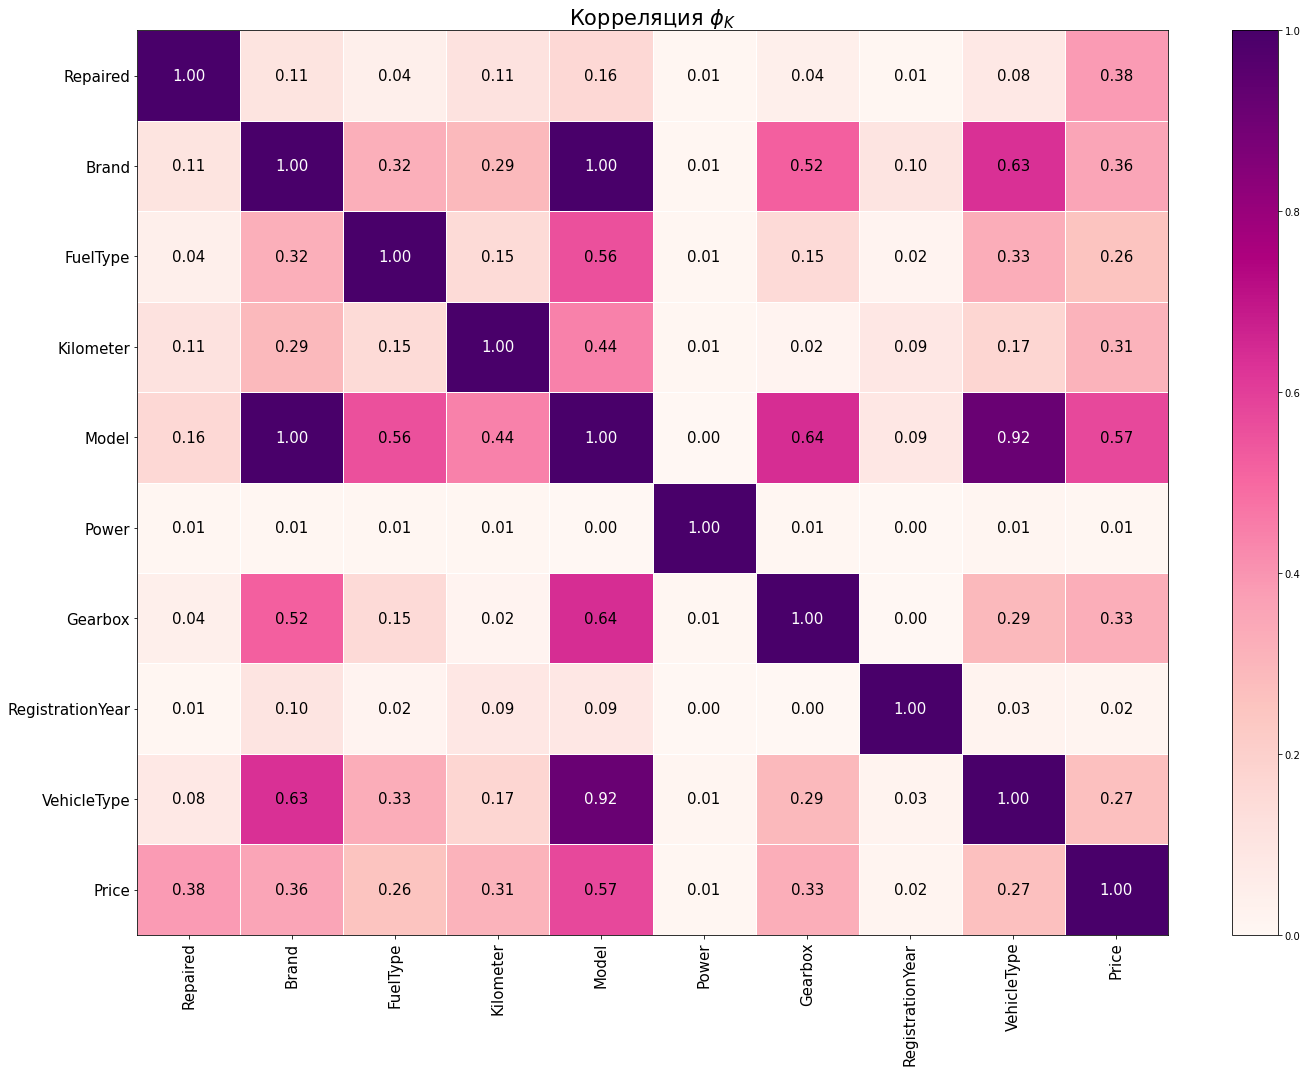

In [ ]:
phikmatrix(df)

Оценка корреляции по шкале Чеддока, где:
- Очень слабая связь — от 0,1 до 0,3.

- Слабая связь — от 0,3 до 0,5.

- Средняя связь — от 0,5 до 0,7.

- Высокая связь — от 0,7 до 0,9.

- Очень высокая связь — от 0,9 до 1,0.


При оценке корреляции с целевым признаком Price наблюдаем:
- Price - Repaired: слабая связь.


- Price - Model: средняя связь.



Model будет сильно перетягивать на себя результат работы модели, количество пропусков 19705, что соcтавляет 5.56% датасета. Удалим пропуски.

In [ ]:
df['Model'] = df['Model'].dropna()

In [ ]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [ ]:
columns = ['Price', 'VehicleType', 'Gearbox', 'Power',
       'Kilometer', 'FuelType', 'Repaired']

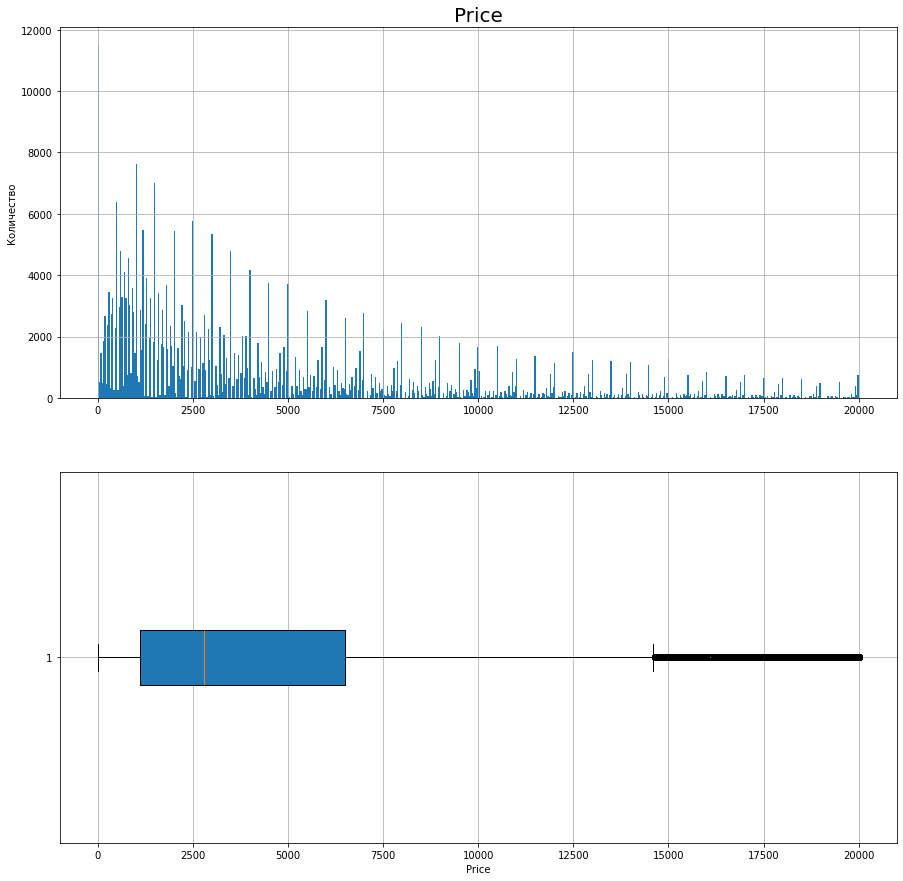

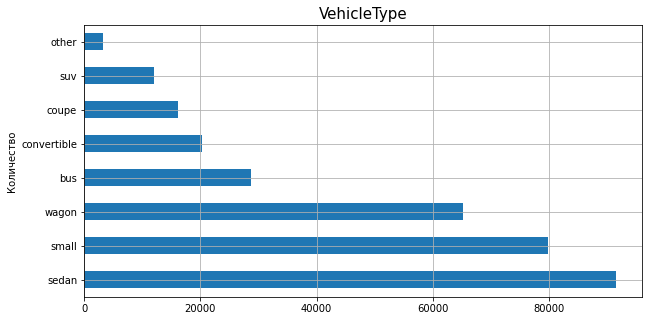

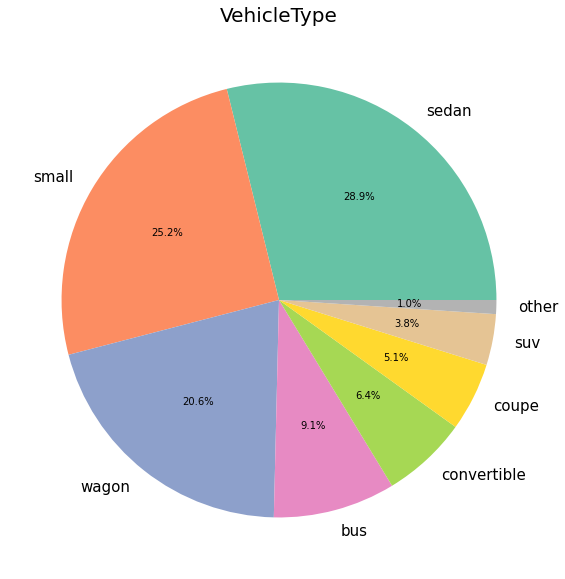

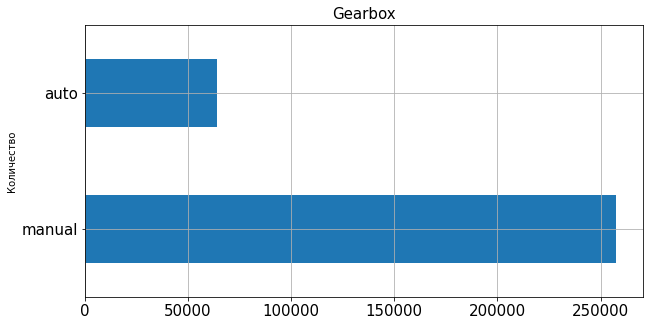

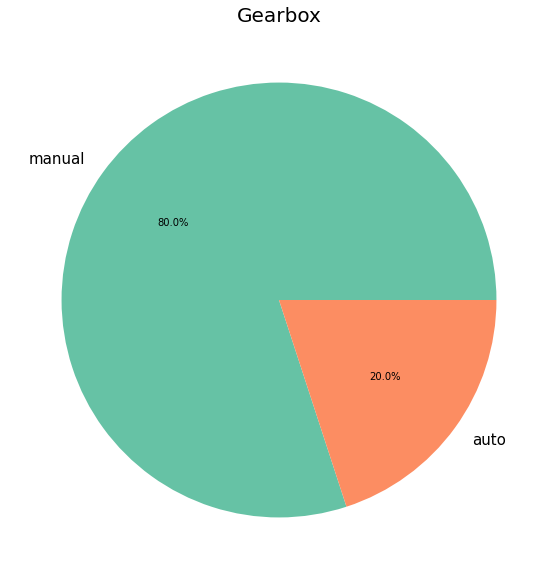

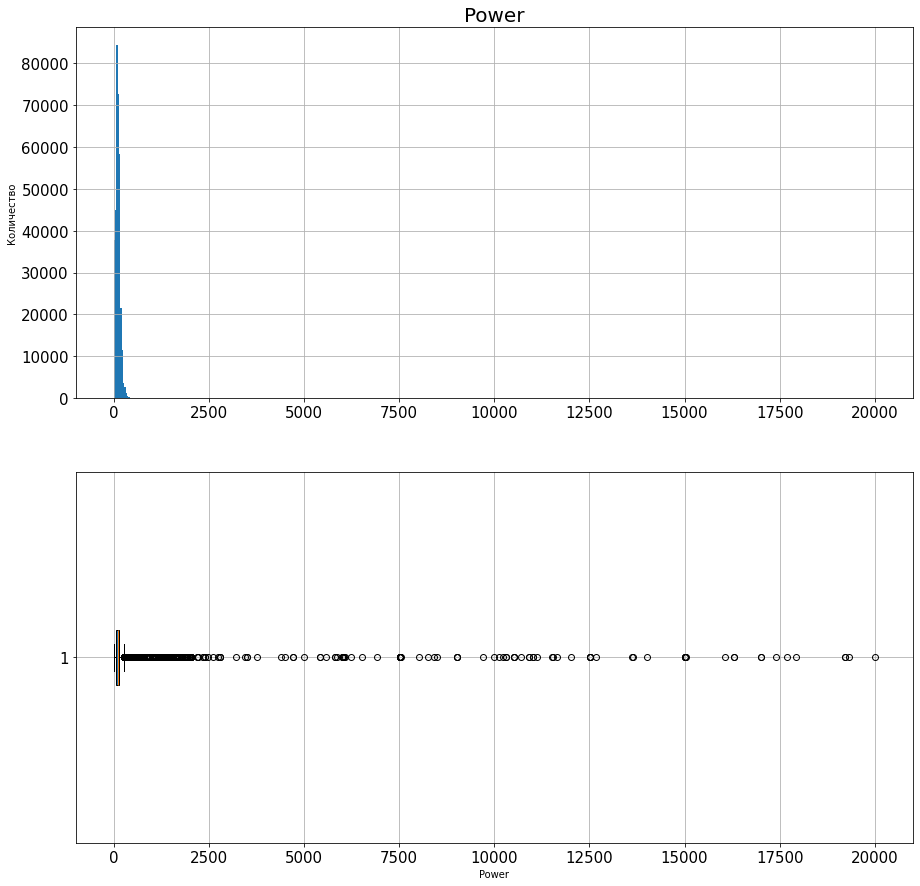

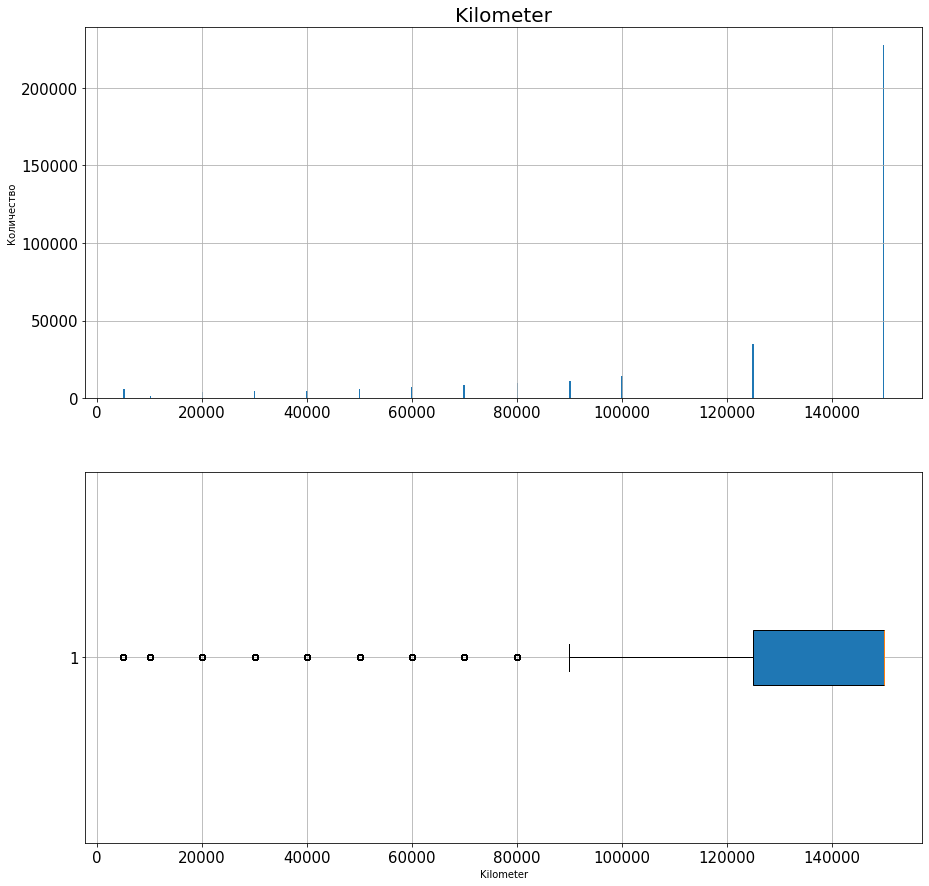

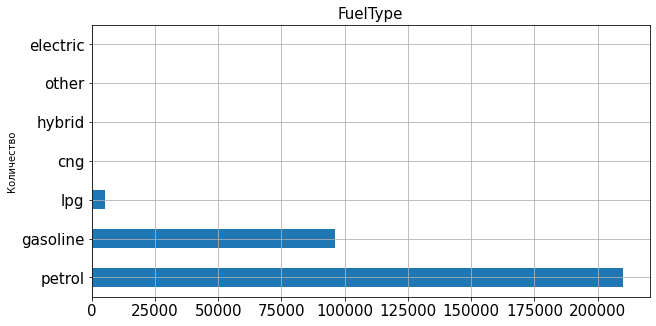

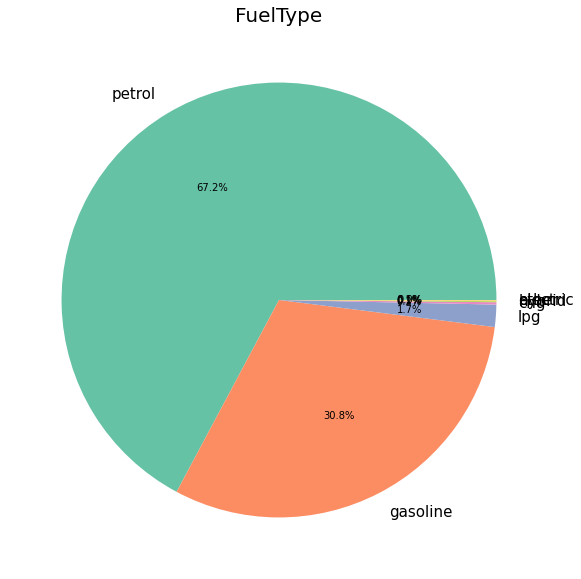

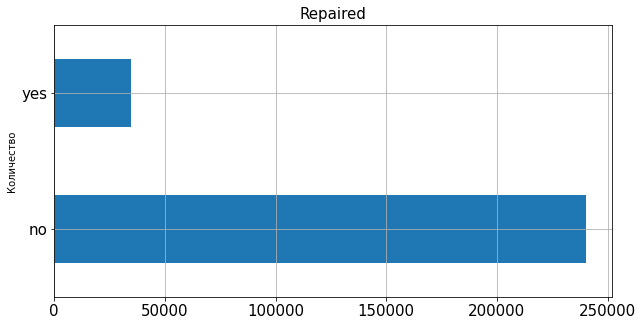

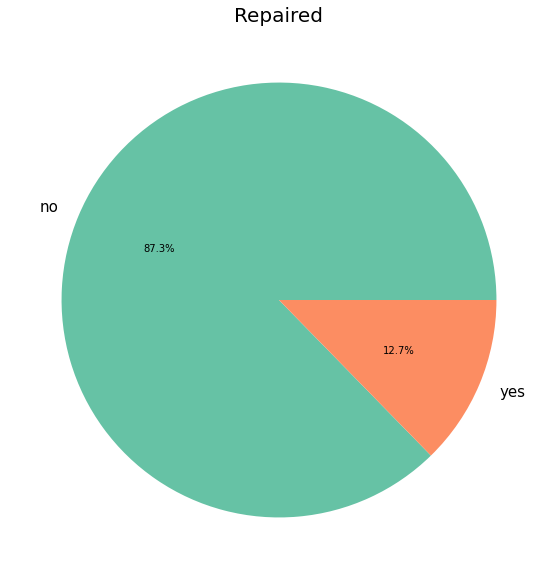

In [ ]:
row_signs(df, columns)

In [ ]:
df['Power'].describe().T

count    339835.000000
mean        111.018385
std         186.977064
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Одна из самых мощный машин в мире Devel Sixteen (5000 л. с.). Отфильтруем выбросы в Power. На коробке с усами видим начало выбросов уже от 1500 л.с. Таким образом возьмём максимальную планку мощности по верхней границе усов.


In [ ]:
df['Power'].quantile(.75) + 1.5 * (df['Power'].quantile(.75) - df['Power'].quantile(.25))


254.0

In [ ]:
drop = df.query('Power > 254')
drop

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
113,6300,sedan,2002,manual,265,golf,150000,petrol,volkswagen,no
125,1800,sedan,1995,auto,286,7er,150000,petrol,bmw,yes
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
...,...,...,...,...,...,...,...,...,...,...
354260,399,other,1994,NaN,1103,3er,150000,NaN,bmw,NaN
354281,6500,sedan,1993,auto,286,5er,150000,petrol,bmw,no
354306,16999,wagon,2008,auto,269,a6,150000,gasoline,audi,no
354337,11500,sedan,2004,auto,445,7er,125000,petrol,bmw,NaN


7123 строки, 2.01% датасета, удалим.

In [ ]:
df.drop(drop.index, inplace=True)

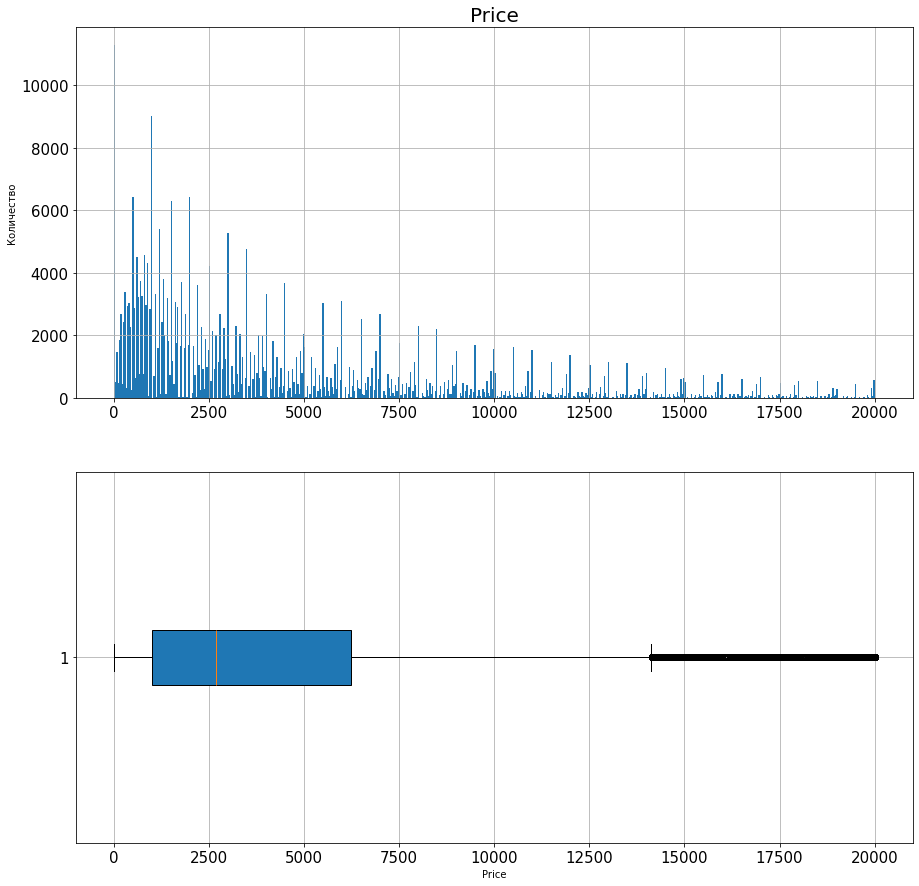

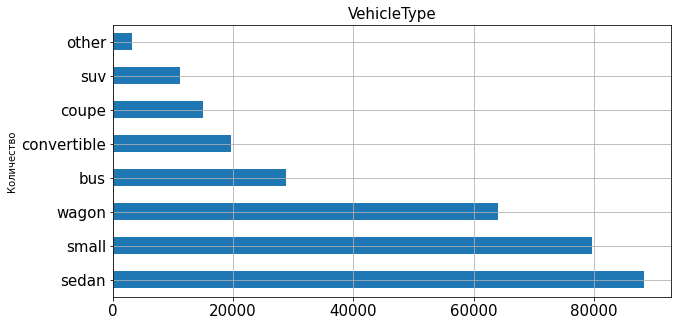

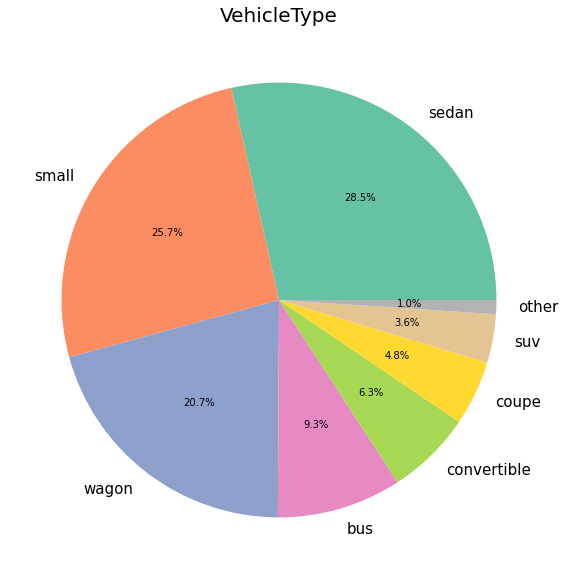

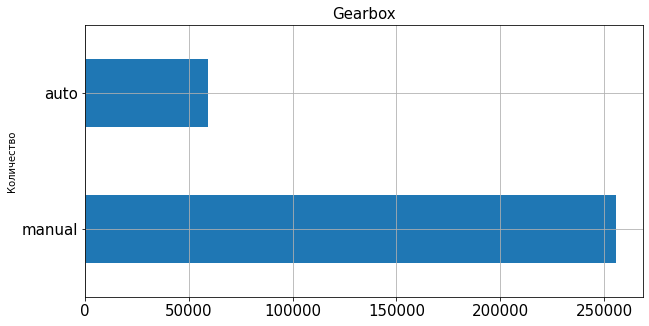

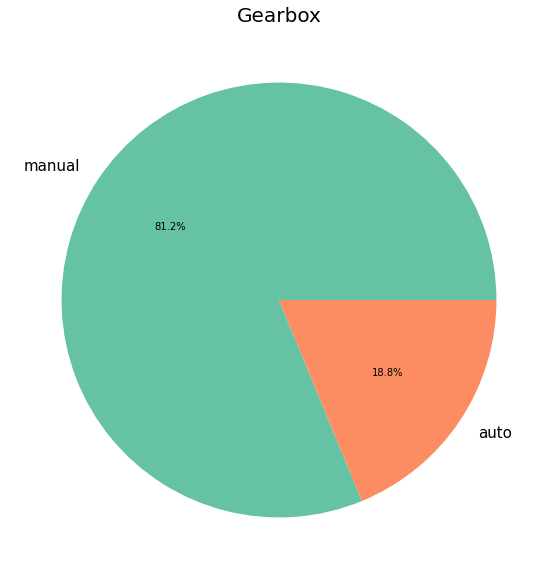

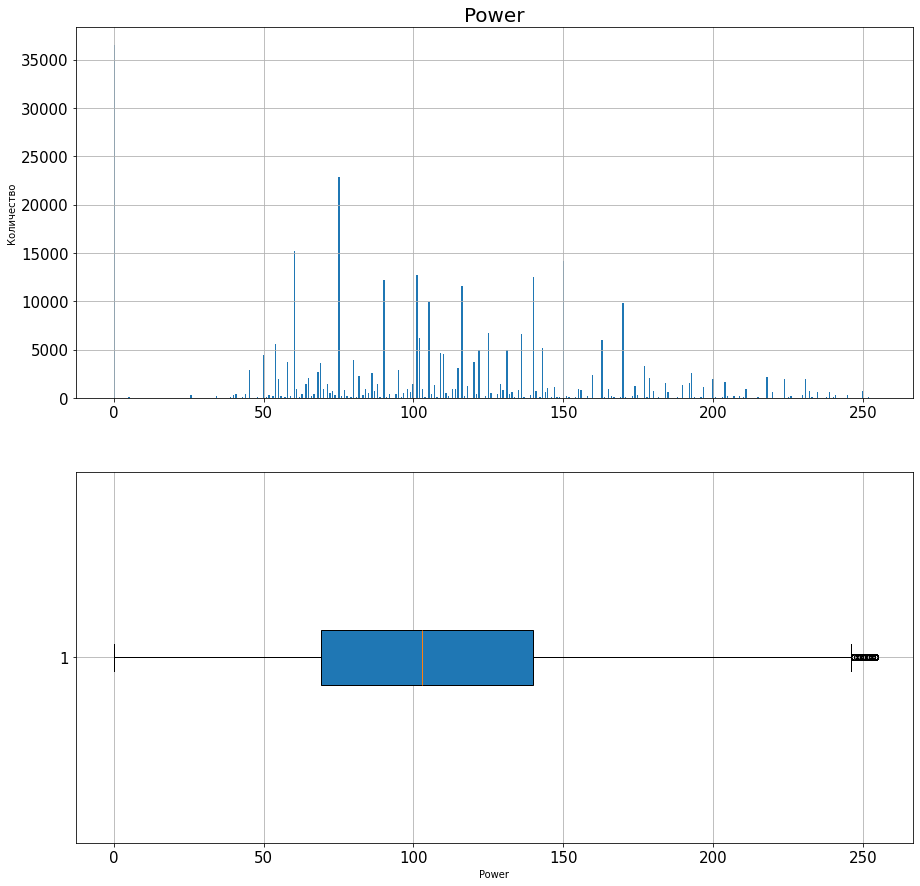

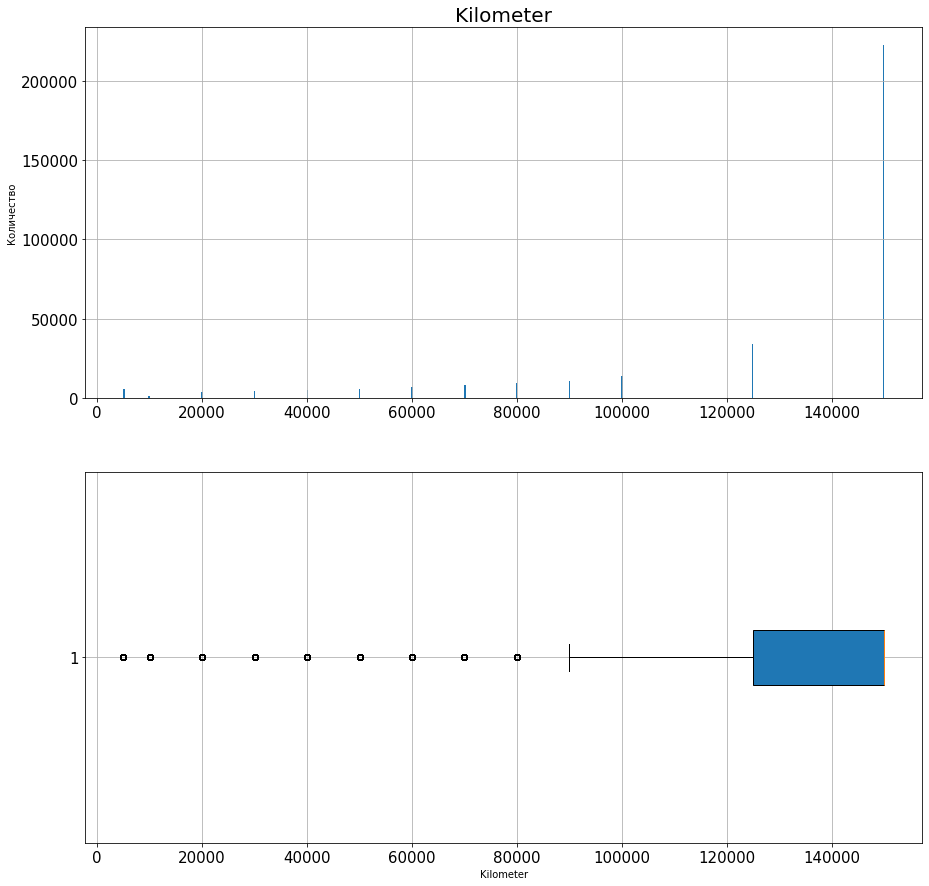

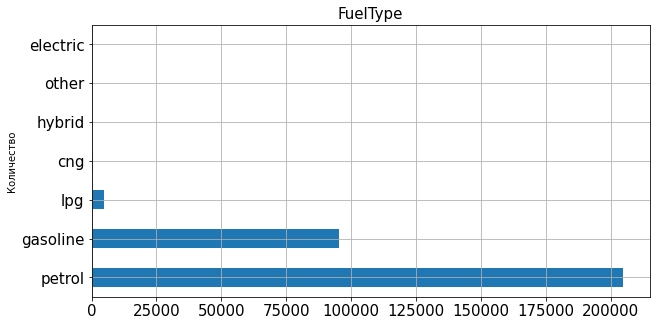

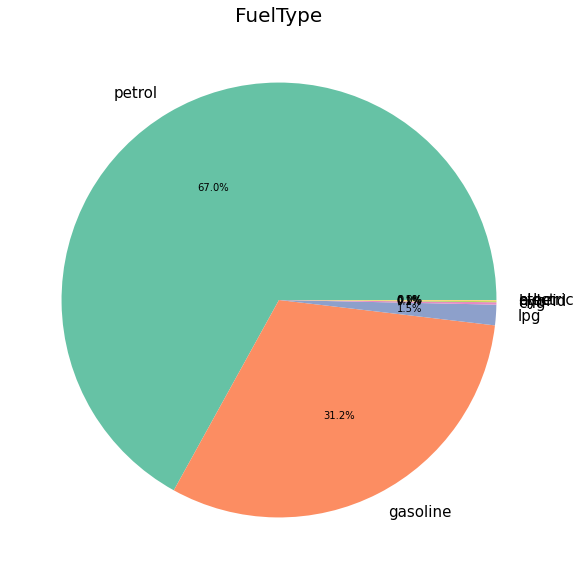

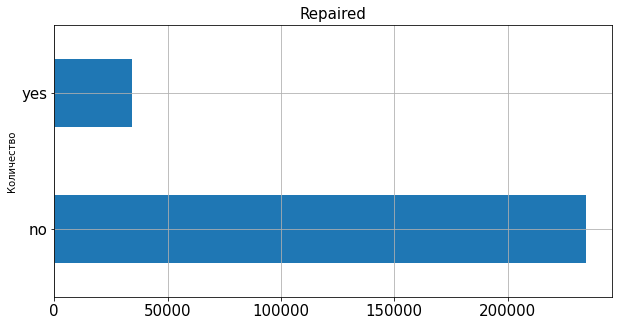

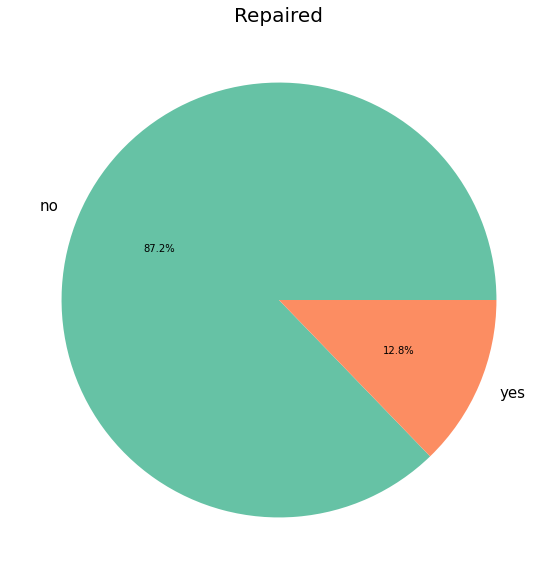

In [ ]:
row_signs(df, columns)

In [ ]:
df.duplicated().sum()

43471

In [ ]:
df = df.drop_duplicates()

### Вывод:

    Удалено:
    - 14530 строки аномального значения RegistrationYear, что составляет 5.1% датасета
    - 19705 пропусков в столбце Model, что соcтавляет 5.56% датасета.
    - 4 явных дубликата.
    - 7123 строки аномального значения Power, 2.01% датасета.
    - неявные дубликаты 43471 строки
    
    Суммарно удалено 84833 строк, что составляет 23.94% датасета.
    

## Обучение моделей

In [ ]:
num_cols = []
cat_cols = []
def types(row, col):
    columns = row.columns
    for column in columns:
        if column != col and column != 'id':
            if row.dtypes[column] == object:
                cat_cols.append(column)
            if row.dtypes[column] == int:
                num_cols.append(column)
    return num_cols, cat_cols

In [ ]:
types(df, 'Price')

(['RegistrationYear', 'Power', 'Kilometer'],
 ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'])

In [ ]:
X = df.drop(['Price'], axis=1)
y = df['Price']

X, X_test, y, y_test = train_test_split(
    X, y,
    test_size=.2,
    random_state=RANDOM_STATE
)

In [ ]:
print(f'Размер тестовой выборки: ', f'{(len(X_test)/len(df)):.0%}')
print(f'Размер тренировочной выборки: ', f'{(len(X)/len(df)):.0%}')

Размер тестовой выборки:  20%
Размер тренировочной выборки:  80%


In [ ]:
param_grid = [
    {   'models': [LGBMRegressor()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },
    {
        'models': [xgb.XGBRegressor(eval_metric="rmse")],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [CatBoostRegressor(loss_function="RMSE", iterations=150, verbose=100)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }

]

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first',
                           handle_unknown='ignore',
                           sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  StandardScaler()),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_cols),
     ('ord', ord_pipe, num_cols),
     ('num', MinMaxScaler(), num_cols)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  DecisionTreeRegressor(random_state=RANDOM_STATE))
     ]
    )


In [ ]:
gscv = GridSearchCV(
    pipe_final,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    verbose=4,
    error_score='raise'
)
%time gscv.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END models=LGBMRegressor(), preprocessor__num=StandardScaler();, score=-1790.531 total time=  45.7s
[CV 2/3] END models=LGBMRegressor(), preprocessor__num=StandardScaler();, score=-1798.426 total time=   6.9s
[CV 3/3] END models=LGBMRegressor(), preprocessor__num=StandardScaler();, score=-1789.031 total time=   7.4s
[CV 1/3] END models=LGBMRegressor(), preprocessor__num=MinMaxScaler();, score=-1790.531 total time=   7.0s
[CV 2/3] END models=LGBMRegressor(), preprocessor__num=MinMaxScaler();, score=-1798.426 total time=   6.9s
[CV 3/3] END models=LGBMRegressor(), preprocessor__num=MinMaxScaler();, score=-1789.031 total time=   7.9s
[CV 1/3] END models=LGBMRegressor(), preprocessor__num=passthrough;, score=-1790.531 total time=   8.3s
[CV 2/3] END models=LGBMRegressor(), preprocessor__num=passthrough;, score=-1798.426 total time=   6.9s
[CV 3/3] END models=LGBMRegressor(), preprocessor__num=passthrough;, score=-1789.03

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Br...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [<catboost.core.CatBoostRegressor object at 0x7f83540ed8e0>],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error', verbose=4)

In [ ]:
print('Лучшая модель и её параметры:\n\n', gscv.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:', gscv.best_score_*(-1))

y_test_pred = gscv.best_estimator_.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {sqrt(mean_squared_error(y_test, y_test_pred))}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                 

## Анализ моделей

In [ ]:
results = pd.DataFrame(gscv.cv_results_)

In [ ]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,18.802075,18.182778,1.204216,0.003394,LGBMRegressor(),StandardScaler(),"{'models': LGBMRegressor(), 'preprocessor__num': StandardScaler()}",-1790.53113,-1798.425606,-1789.030829,-1792.662521,4.120888,7
1,6.031702,0.463221,1.233065,0.041317,LGBMRegressor(),MinMaxScaler(),"{'models': LGBMRegressor(), 'preprocessor__num': MinMaxScaler()}",-1790.53113,-1798.425606,-1789.030829,-1792.662521,4.120888,7
2,6.300067,0.610512,1.299042,0.083737,LGBMRegressor(),passthrough,"{'models': LGBMRegressor(), 'preprocessor__num': 'passthrough'}",-1790.53113,-1798.425606,-1789.030829,-1792.662521,4.120888,7
3,326.480277,27.751770,1.214721,0.017013,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, eval_metric='rmse', gamma=None,\n gpu_id=None, importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",StandardScaler(),"{'models': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, enable_categorical=False, eval_metric='rmse', gamma=None, gpu_id=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, subsample=None, tree_method=None, validate_parameters=None, verbosity=None), 'preprocessor__num': StandardScaler()}",-1760.33352,-1766.849856,-1765.581042,-1764.254806,2.820737,4
4,319.479277,35.845889,1.147595,0.040042,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, eval_metric='rmse', gamma=None,\n gpu_id=None, importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",MinMaxScaler(),"{'models': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, enable_categorical=False, eval_metric='rmse', gamma=None, gpu_id=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, subsample=None, tree_method=None, validate_parameters=None, verbosity=None), 'preprocessor__num': MinMaxScaler()}",-1760.33352,-1766.849856,-1765.581042,-1764.254806,2.820737,4


In [ ]:
result_1 = pd.DataFrame(gscv.cv_results_)
result_1 = result_1[
    ['rank_test_score',
     'mean_test_score',
     'param_models',
     'mean_fit_time'
    ]
].sort_values('rank_test_score')
result_1

,rank_test_score,mean_test_score,param_models,mean_fit_time
9,1,-1754.669408,<catboost.core.CatBoostRegressor object at 0x7f83540ed8e0>,16.546019
10,1,-1754.669408,<catboost.core.CatBoostRegressor object at 0x7f83540ed8e0>,16.392155
11,1,-1754.669408,<catboost.core.CatBoostRegressor object at 0x7f83540ed8e0>,16.500979
3,4,-1764.254806,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, eval_metric='rmse', gamma=None,\n gpu_id=None, importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",326.480277
4,4,-1764.254806,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, eval_metric='rmse', gamma=None,\n gpu_id=None, importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",319.479277
5,4,-1764.254806,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, eval_metric='rmse', gamma=None,\n gpu_id=None, importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",307.969069
0,7,-1792.662521,LGBMRegressor(),18.802075
1,7,-1792.662521,LGBMRegressor(),6.031702
2,7,-1792.662521,LGBMRegressor(),6.300067
6,10,-2967.075745,LinearRegression(),14.297372


## Вывод:

Все модели имеют метрику RMSE ниже 2500 евро

CatBoost имеет самую лучшую метрику средней квадратичной ошибки- 1754.66 и более быструю скорость загрузки в сравнении с XGBRegressor.

Модели успешно встроены в пайплайн, что облегчает работу.


## Общий вывод:

**Из датасета исключены неинформативные столбцы:**
- Столбец NumberOfPictures не информативен и содержит всего одно значение.
- PostalCode — почтовый индекс владельца анкеты (пользователя).
- DateCrawled.
- LastSeen.
- RegistrationMonth.
- DateCreated.

   **Удалено:**
    - 14530 строки аномального значения RegistrationYear, что составляет 5.1% датасета
    - 19705 пропусков в столбце Model, что соcтавляет 5.56% датасета.
    - 4 явных дубликата
    - 7123 строки аномального значения Power, 2.01% датасета.
    - неявные дубликаты 43471 строки
    
    **Суммарно удалено 84833 строк, что составляет 23.94% датасета.**
   


**Выделена лучшая модель: CatBoostRegressor**

In [ ]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   StandardScaler()),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x7f83541617f0>)])

**Метрика RMSE лучшей модели на тренировочной выборке равна 1754.66**

**Метрика RMSE лучшей модели на тестовой выборке равна 1757.14**